In [0]:
#%env CUDA_VISIBLE_DEVICES=2

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.chdir('/content/drive/My Drive/Detecto_Face')

In [0]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [12]:
# Load the Data

# Set train and val directory paths

dataset = 'ntrain_faces_categories'

train_directory = os.path.join(dataset, 'train')
val_directory = os.path.join(dataset, 'val')
test_directory = os.path.join(dataset, 'val')

# Batch size
bs = 32

# Number of classes
num_classes = 5
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'val': datasets.ImageFolder(root=val_directory, transform=image_transforms['val']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
val_data_size = len(data['val'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
val_data_loader = DataLoader(data['val'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

5
{0: 'Unknown', 1: 'angry', 2: 'happy', 3: 'sad', 4: 'surprised'}


In [34]:
train_data_size, val_data_size, test_data_size

(1320, 279, 279)

In [0]:
res_mod = models.resnet152(pretrained=True)

num_ftrs = res_mod.fc.in_features

res_mod.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), # Since 5 possible outputs
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

In [0]:
import torch.optim as optim
from torch.optim import lr_scheduler

res_mod = res_mod.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(res_mod.parameters(), lr=0.001, momentum=0.9)
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [0]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and valate
    Parameters
        :param model: Model to train and valate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best valation accuracy
        history: (dict object): Having training loss, accuracy and valation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        val_loss = 0.0
        val_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # valation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # valation loop
            for j, (inputs, labels) in enumerate(val_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to val_loss
                val_loss += loss.item() * inputs.size(0)

                # Calculate valation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to val_acc
                val_acc += acc.item() * inputs.size(0)

                #print("valation Batch number: {:03d}, valation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_val_loss = val_loss/val_data_size 
        avg_val_acc = val_acc/val_data_size

        history.append([avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tvalation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_val_loss, avg_val_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history
    

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Print the model to be trained
#summary(resnet50, input_size=(3, 224, 224), batch_size=bs, device='cuda')

# Train the model for 25 epochs
num_epochs = 30
trained_model, history = train_and_validate(res_mod, loss_func, optimizer_ft, num_epochs)

torch.save(history, dataset+'_history.pt')

Epoch: 1/30
Epoch : 000, Training: Loss: 1.5250, Accuracy: 29.7727%, 
		valation : Loss : 1.7435, Accuracy: 22.2222%, Time: 47.7447s
Epoch: 2/30
Epoch : 001, Training: Loss: 1.4045, Accuracy: 44.0152%, 
		valation : Loss : 1.6496, Accuracy: 24.7312%, Time: 47.8485s
Epoch: 3/30
Epoch : 002, Training: Loss: 1.2295, Accuracy: 51.9697%, 
		valation : Loss : 1.5607, Accuracy: 30.8244%, Time: 47.9486s
Epoch: 4/30
Epoch : 003, Training: Loss: 1.0395, Accuracy: 58.9394%, 
		valation : Loss : 1.5003, Accuracy: 36.9176%, Time: 48.4184s
Epoch: 5/30
Epoch : 004, Training: Loss: 0.8519, Accuracy: 68.0303%, 
		valation : Loss : 1.4311, Accuracy: 40.1434%, Time: 48.0880s
Epoch: 6/30
Epoch : 005, Training: Loss: 0.6791, Accuracy: 78.0303%, 
		valation : Loss : 1.5143, Accuracy: 42.2939%, Time: 48.5185s
Epoch: 7/30
Epoch : 006, Training: Loss: 0.5097, Accuracy: 83.7121%, 
		valation : Loss : 1.4997, Accuracy: 45.8781%, Time: 48.9368s
Epoch: 8/30
Epoch : 007, Training: Loss: 0.3767, Accuracy: 88.1818%, 

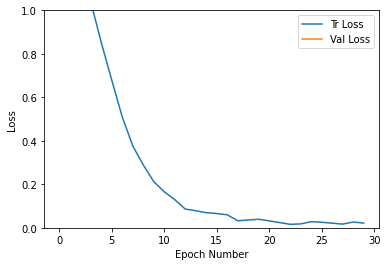

In [42]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()


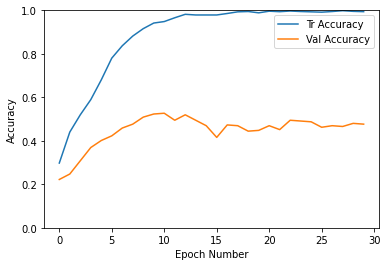

In [43]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [0]:
 def computeTestSetAccuracy(model, loss_criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    print("Test accuracy : " + str(avg_test_acc))


In [0]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(3, dim=1)
        for i in range(3):
            print("Predcition", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])
    return  idx_to_class[topclass.cpu().numpy()[0][0]]

In [0]:
# Test a particular model on a test image
dataset = 'ntrain_faces_categories'
model = torch.load('ntrain_faces_categories_model_29.pt')

In [0]:
import pandas as pd
import tqdm
df_test = pd.read_csv('test.csv')
df_sample_submission = pd.read_csv('sample_submission.csv')

In [6]:
test_path='ntest'

for img in df_test.image_file:  
  print(os.path.join(test_path,img+'.jpg'))

len(os.listdir(test_path))  

275

In [0]:
y_pred=predict(model, 'ntest_faces/IMG_10000166f.jpg')

# Load Data from folders
#computeTestSetAccuracy(model, loss_func)  
y_pred     

In [0]:
%%sh
pip3 install detecto

In [0]:
from detecto import core, utils, visualize

In [17]:
face_detect_model = core.Model.load('model_weights2.pth', ['jerry', 'tom'])

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [0]:
dict_num2class={0:'angry', 1:'happy', 2:'sad', 3:'surprised', 4:'Unknown'}
dict_class2num={'angry':0, 'happy':1, 'sad':2, 'surprised':3, 'Unknown':4}

In [0]:
from PIL import Image
def predict2(model, test_image):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    test_image = Image.fromarray(test_image)
    transform = image_transforms['test']

    #test_image = Image.open(test_image_name)
    #plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(3, dim=1)
        #for i in range(3):
            #print("Predcition", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])
    return  idx_to_class[topclass.cpu().numpy()[0][0]]

def getCroppedImage(box,img):
  box=[int(item) for item in box]
  left,top,right,bottom=box[0],box[1],box[2],box[3]
  #print(left,right,top,bottom)
  crop_img=img[top:bottom,left:right]

  return crop_img
def PredictEmotion(image_paths):

   y_pred=[]

   
   for item in image_paths:
     #print(item)     
     image = utils.read_image(item)
     labels, boxes, scores = face_detect_model.predict(image)
     
     if(len(boxes)!=0):
       crop_img = getCroppedImage(boxes[0],image)
       label_str=predict2(model, crop_img)
       label_num=dict_class2num[label_str]
       print('Found Box')
     else:  
       label_num=dict_class2num['Unknown'] 
       print('Box not found')
     print(item,label_str,label_num) 
     y_pred.append(label_num)     
   return y_pred

In [0]:
images_path='ntest'
test_images=[os.path.join(images_path,img+'.jpg')  for img in df_test.image_file]
y_pred=PredictEmotion(test_images)

In [0]:
y_pred

In [95]:
# replacing the label with prediction
df_sample_submission['emotion'] = y_pred
df_sample_submission.head()

,emotion
0,2
1,4
2,1
3,2
4,1


In [0]:
# saving the file
df_sample_submission.to_csv('submission.csv', index=False)

In [0]:
output_emotions=[dict_num2class[item] for item in y_pred]
df_output=df_test.copy()
df_output['file_path']=test_images
df_output['emotion']=output_emotions
df_output.head()

In [0]:
import cv2
for item in df_output.head(6).itertuples():
  
  im=cv2.imread(item[2])
  plt.imshow(im)
  plt.axis('off')
  plt.title(item[3])
  plt.show()    